# End-to-End Machine Learning Pipeline I

Bu kısımda yapacağımız işlemler:

1. Exploratory Data Analysis
2. Data Preprocessing & Feature Engineering
3. Base Models
4. Automated Hyperparameter Optimization
5. Stacking & Ensemble Learning
6. Prediction for a New Observation
7. Pipeline Main Function

Bu kapsamda veri ön işleme, değişken mühendisliği gibi işlemlerin otomasyonunu, temel modelleri gösterme işleminin otomasyonunu, hiperparametre optimizasyonu işleminin otomasyonunu, stacking & ensemble learning kavramını, daha sonra burada yaptığımız tüm çalışmaları bir pipline'da bir araya getiyor olacağız.

### Import İşlemleri

In [1]:
import warnings
import joblib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

# !pip install catboost
# !pip install lightgbm
# !pip install xgboost

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier

pd.set_option('display.max_columns', None)
# pd.set_option('display.width', 500)

warnings.simplefilter(action='ignore', category=Warning)

C:\Users\btskd\anaconda3\envs\pipeline_project\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
C:\Users\btskd\anaconda3\envs\pipeline_project\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## 1. Exploratory Data Analysis

Buraya bir çok fonksiyon tanımlayacağız fakat hepsini kullanmayacağız. Burası deneysel bir alan. Hangi fonksiyonları kullanacağımıza burada karar verip daha sonrasında sadece kullandığımız fonksiyonları bir pipeline dosyasına geçireceğiz.

In [2]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Info #####################")
    print(dataframe.info())
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### Null Values #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)


def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.

    Parameters
    ----------
    dataframe: dataframe
        Değişken isimleri alınmak istenen dataframe'dir.
    cat_th: int, float
        Numerik fakat kategorik olan değişkenler için sınıf eşik değeri.
    car_th: int, float
        Kategorik fakat kardinal değişkenler için sınıf eşik değeri.

    Returns
    -------
    cat_cols: list
        Kategorik değişken listesi.
    num_cols: list
        Numerik değişken listesi.
    cat_but_car: list
        Kategorik görünümlü kardinal değişken listesi.

    Notes
    ------
    cat_cols + num_cols + cat_but_car = toplam değişken sayısı
    num_but_cat, cat_cols'un içerisinde.

    """
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["object", "category", "bool", "uint8"]]

    num_but_cats = [col for col in dataframe.columns if dataframe[col].dtypes in ["int64", "float64"] and dataframe[col].nunique() < cat_th]

    cat_but_cars = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["object", "category"] and dataframe[col].nunique() > car_th]

    cat_cols = cat_cols + num_but_cats
    cat_cols = [col for col in cat_cols if col not in cat_but_cars]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ["int64", "float64"]]
    num_cols = [col for col in num_cols if col not in cat_cols]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f"cat_cols: {len(cat_cols)}")
    print(f"num_cols: {len(num_cols)}")
    print(f"cat_but_car: {len(cat_but_cars)}")
    print(f"num_but_cat: {len(num_but_cats)}")

    return cat_cols, num_cols, cat_but_cars


def cat_summary(dataframe, col_name, plot=False):
    import pandas as pd
    
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("#######################")

    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show(block=True)


def num_summary(dataframe, col_name, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[col_name].describe(quantiles).T)

    if plot:
        dataframe[col_name].hist()
        plt.xlabel(col_name)
        plt.title(col_name)
        plt.show(block=True)


def target_summary_wCat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}))


def target_summary_wNum(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}))

    
def correlation_matrix(df, cols):
    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    fig = sns.heatmap(df[cols].corr(), annot=True, linewidths=0.5, annot_kws={'size': 12},linecolor='w', cmap='RdBu')
    plt.show(block=True)

In [3]:
df = pd.read_csv("../datasets/diabetes.csv")

In [4]:
check_df(df)

##################### Shape #####################
(768, 9)
##################### Types #####################
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object
##################### Info #####################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI       

### Değişken türlerinin ayrıştırılması

In [5]:
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [6]:
cat_cols

['Outcome']

In [7]:
num_cols

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

### Kategorik değişkenlerin incelenmesi

In [8]:
for col in cat_cols:
    cat_summary(df, col)

   Outcome      Ratio
0      500  65.104167
1      268  34.895833
#######################


### Sayısal değişkenlerin incelenmesi 

In [9]:
df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00


Eğer bu sayısal değişkenlerin grafiğini çizdirmek istersek:

count    768.000000
mean       3.845052
std        3.369578
min        0.000000
5%         0.000000
10%        0.000000
20%        1.000000
30%        1.000000
40%        2.000000
50%        3.000000
60%        4.000000
70%        5.000000
80%        7.000000
90%        9.000000
95%       10.000000
99%       13.000000
max       17.000000
Name: Pregnancies, dtype: float64


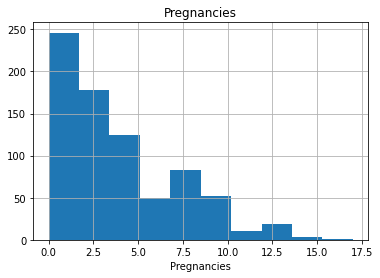

count    768.000000
mean     120.894531
std       31.972618
min        0.000000
5%        79.000000
10%       85.000000
20%       95.000000
30%      102.000000
40%      109.000000
50%      117.000000
60%      125.000000
70%      134.000000
80%      147.000000
90%      167.000000
95%      181.000000
99%      196.000000
max      199.000000
Name: Glucose, dtype: float64


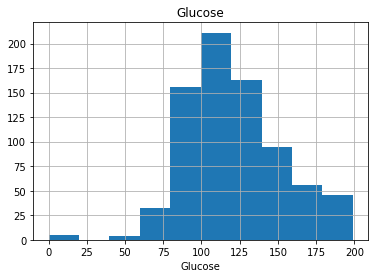

count    768.000000
mean      69.105469
std       19.355807
min        0.000000
5%        38.700000
10%       54.000000
20%       60.000000
30%       64.000000
40%       68.000000
50%       72.000000
60%       74.000000
70%       78.000000
80%       82.000000
90%       88.000000
95%       90.000000
99%      106.000000
max      122.000000
Name: BloodPressure, dtype: float64


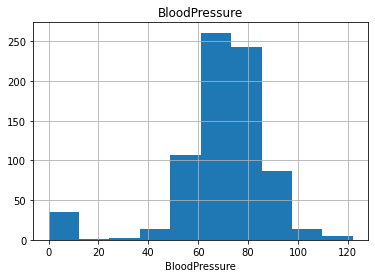

count    768.000000
mean      20.536458
std       15.952218
min        0.000000
5%         0.000000
10%        0.000000
20%        0.000000
30%        8.200000
40%       18.000000
50%       23.000000
60%       27.000000
70%       31.000000
80%       35.000000
90%       40.000000
95%       44.000000
99%       51.330000
max       99.000000
Name: SkinThickness, dtype: float64


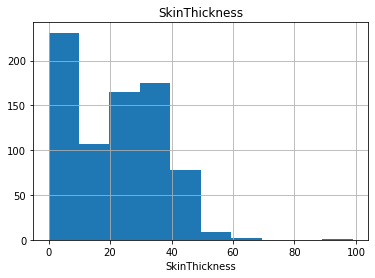

count    768.000000
mean      79.799479
std      115.244002
min        0.000000
5%         0.000000
10%        0.000000
20%        0.000000
30%        0.000000
40%        0.000000
50%       30.500000
60%       72.200000
70%      106.000000
80%      150.000000
90%      210.000000
95%      293.000000
99%      519.900000
max      846.000000
Name: Insulin, dtype: float64


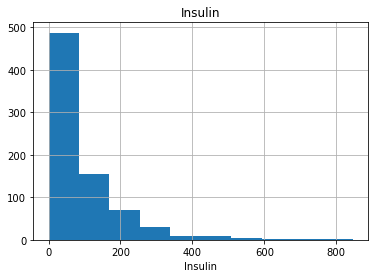

count    768.000000
mean      31.992578
std        7.884160
min        0.000000
5%        21.800000
10%       23.600000
20%       25.900000
30%       28.200000
40%       30.100000
50%       32.000000
60%       33.700000
70%       35.490000
80%       37.800000
90%       41.500000
95%       44.395000
99%       50.759000
max       67.100000
Name: BMI, dtype: float64


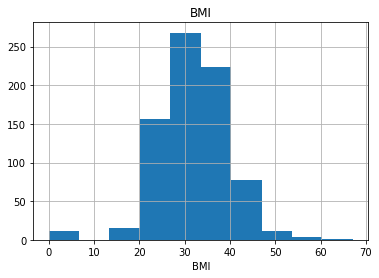

count    768.000000
mean       0.471876
std        0.331329
min        0.078000
5%         0.140350
10%        0.165000
20%        0.219400
30%        0.259000
40%        0.302800
50%        0.372500
60%        0.454200
70%        0.563700
80%        0.687000
90%        0.878600
95%        1.132850
99%        1.698330
max        2.420000
Name: DiabetesPedigreeFunction, dtype: float64


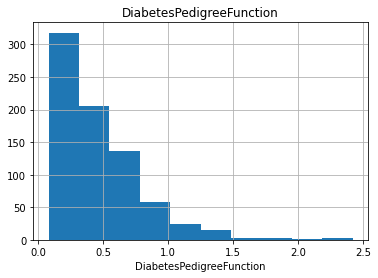

count    768.000000
mean      33.240885
std       11.760232
min       21.000000
5%        21.000000
10%       22.000000
20%       23.000000
30%       25.000000
40%       27.000000
50%       29.000000
60%       33.000000
70%       38.000000
80%       42.600000
90%       51.000000
95%       58.000000
99%       67.000000
max       81.000000
Name: Age, dtype: float64


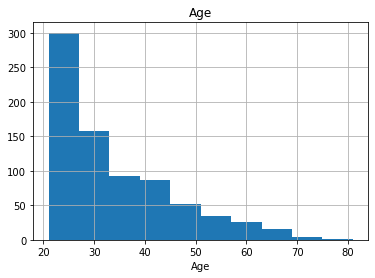

In [10]:
for col in num_cols:
    num_summary(df, col, plot=True)

Görsel çıktı veren kodları yorumladıktan ve alacaklarımızı aldıktan sonra o satırı comment şekilde bırakıyoruz ki tekrar tekrar çalıştırdığımızda sürekli grafik çizdirmesin.

### Sayısal değişlenlerin birbirleri ile korelasyonu

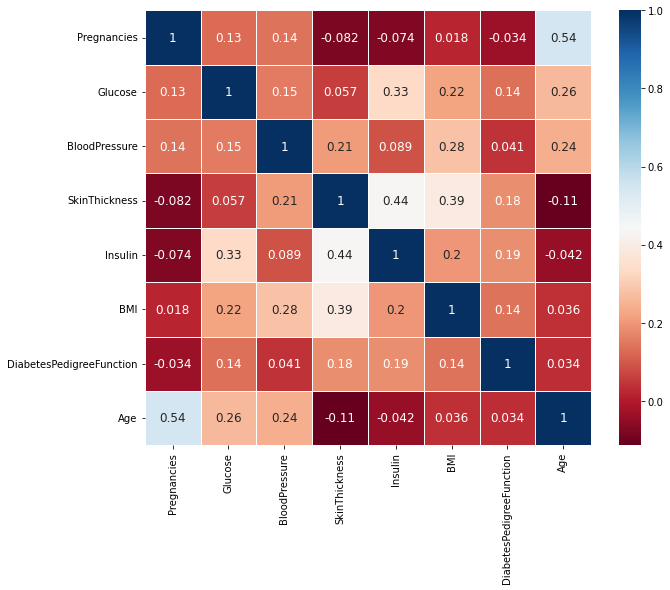

In [11]:
correlation_matrix(df, num_cols)

### Target ile sayısal değişkenlerin incelenmesi

In [12]:
for col in num_cols:
    target_summary_wNum(df, "Outcome", col)

         Pregnancies
Outcome             
0           3.298000
1           4.865672
            Glucose
Outcome            
0        109.980000
1        141.257463
         BloodPressure
Outcome               
0            68.184000
1            70.824627
         SkinThickness
Outcome               
0            19.664000
1            22.164179
            Insulin
Outcome            
0         68.792000
1        100.335821
               BMI
Outcome           
0        30.304200
1        35.142537
         DiabetesPedigreeFunction
Outcome                          
0                        0.429734
1                        0.550500
               Age
Outcome           
0        31.190000
1        37.067164


## 2. Data Preprocessing & Feature Engineering

Bu bölümde bu veri setindeki olası problemleri çözüp, yeni değişkenler türetip bu işlemleri bir fonksiyonca tanımlamaya çalışacağız. Kullanacak olduğumuz fonksiyonlar aşağıdaki gibidir:

In [13]:
def outlier_thresholds(dataframe, num_col, q1=0.25, q3=0.75):
    quartile1 = dataframe[num_col].quantile(q1)
    quartile3 = dataframe[num_col].quantile(q3)
    iqr = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * iqr
    low_limit = quartile1 - 1.5 * iqr

    # outliers = [dataframe[(dataframe[num_col] < low) | (dataframe[num_col] > up)]]
    return low_limit, up_limit


def check_outlier(dataframe, num_col, q1=0.25, q3=0.75):
    low_limit, up_limit = outlier_thresholds(dataframe, num_col, q1, q3)

    if dataframe[(dataframe[num_col] < low_limit) | (dataframe[num_col] > up_limit)].any(axis=None):
        return True
    else:
        return False

    
def replace_with_thresholds(dataframe, num_col):
    low_limit, up_limit = outlier_thresholds(dataframe, num_col)

    dataframe.loc[(dataframe[num_col] < low_limit), num_col] = low_limit
    dataframe.loc[(dataframe[num_col] > up_limit), num_col] = up_limit
    

def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    # fonksiyona girilen dataframe içerisinden kategorik değişkenleri one hot encoding işlemine sokuyoruz
    # sonrasında ana dataframe'e bunu kaydederek fonksiyon sonunda bu df'i döndürüyoruz.
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [14]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Veri setindeki değişkenlerimizin isimleri büyük ve küçük harflerden oluşuyor. Bunun bir karışıklığa sebep olmaması için bütün değişken isimlerini büyük harfler ile yazdırıyoruz.

### Değişken isimlerini büyütmek

In [15]:
df.columns = [col.upper() for col in df.columns]

In [16]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### Yeni Değişkenler Üretme

**Glucose**

Glükoz değeri, şeker hastalığı ile direkt olarak ilişkili bir değer olduğundan dolayı glükoz değeri 0-139 arasında olanlara *normal*, 139-200 arasında olanlara *prediabetes* olarak isimlendiriyoruz.

In [17]:
df["NEW_GLUCOSE_CAT"] = pd.cut(x=df['GLUCOSE'], bins=[-1, 139, 200], labels=["normal", "prediabetes"])

In [18]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_GLUCOSE_CAT
0,6,148,72,35,0,33.6,0.627,50,1,prediabetes
1,1,85,66,29,0,26.6,0.351,31,0,normal
2,8,183,64,0,0,23.3,0.672,32,1,prediabetes
3,1,89,66,23,94,28.1,0.167,21,0,normal
4,0,137,40,35,168,43.1,2.288,33,1,normal


Yeni bir değişken oluşturduğumuz zaman o değişkeni oluşturmak için kullandığımız orijinal değişkeni hemen veri setinden silmiyoruz. Onun yerine modelleme aşamasına gelene kadar tutuyoruz. Eğer yüksek kolerasyon oluşursa o halde silme işlemini yapabiliriz. Şimdilik bir şey yapmıyoruz.

**Age**

Yaşı 35'ten küçük olanları *young*, 35-55 arasında olanları *middleage*, 55'ten büyük olanları *old* sınıflarına ayıralım.

In [19]:
df.loc[(df["AGE"] < 35), "NEW_AGE_CAT"] = 'young'
df.loc[(df["AGE"] >= 35) & (df["AGE"] <= 55), "NEW_AGE_CAT"] = 'middleage'
df.loc[(df["AGE"] > 55), "NEW_AGE_CAT"] = 'old'

**BMI**

BMI değeri 0-18.5 olanları *underweight*, 18.5-24.9 olanları *healty*, 24.9-29.9 olanları *overweight*, 29.9-100 olanları *obese* sınıfına ayıralım.

In [20]:
df["NEW_BMI_RANGE"] = pd.cut(x=df["BMI"], bins=[-1, 18.5, 24.9, 29.9, 100], labels=["underweight", "healty", "overweight", "obese"])

**Blood Pressure**

Kan basıncı değeri 0-79 olanları *normal*, 79-89 olanları *hs1*, 89-123 olanları *hs2* sınıflarına ayıralım.

In [21]:
df["NEW_BLOODPRESSURE"] = pd.cut(x=df["BLOODPRESSURE"], bins=[-1, 79, 89, 123], labels=["normal", "hs1", "hs2"])

### Yeni Değişkenlerin Analizi

In [22]:
check_df(df)

##################### Shape #####################
(768, 13)
##################### Types #####################
PREGNANCIES                    int64
GLUCOSE                        int64
BLOODPRESSURE                  int64
SKINTHICKNESS                  int64
INSULIN                        int64
BMI                          float64
DIABETESPEDIGREEFUNCTION     float64
AGE                            int64
OUTCOME                        int64
NEW_GLUCOSE_CAT             category
NEW_AGE_CAT                   object
NEW_BMI_RANGE               category
NEW_BLOODPRESSURE           category
dtype: object
##################### Info #####################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   PREGNANCIES               768 non-null    int64   
 1   GLUCOSE                   768 non-null    int64   
 2   BLOODPRESSUR

Ara ara kod akışı ortasında df'imizde herhangi bir problemin olup olmadığını gözlemlemek amacıyla *check_df* fonksiyonumuzu kullanabiliriz.

Artık yeni değişkenlerimiz olduğundan dolayı değişkenlerimizi türlerine göre ayırma işlemini tekrar yapmamız gerekiyor.

In [23]:
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)

Observations: 768
Variables: 13
cat_cols: 5
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [24]:
cat_cols

['NEW_GLUCOSE_CAT',
 'NEW_AGE_CAT',
 'NEW_BMI_RANGE',
 'NEW_BLOODPRESSURE',
 'OUTCOME']

In [25]:
for col in cat_cols:
    cat_summary(df, col)

             NEW_GLUCOSE_CAT      Ratio
normal                   571  74.348958
prediabetes              197  25.651042
#######################
           NEW_AGE_CAT      Ratio
young              488  63.541667
middleage          230  29.947917
old                 50   6.510417
#######################
             NEW_BMI_RANGE      Ratio
obese                  472  61.458333
overweight             179  23.307292
healty                 102  13.281250
underweight             15   1.953125
#######################
        NEW_BLOODPRESSURE      Ratio
normal                563  73.307292
hs1                   145  18.880208
hs2                    60   7.812500
#######################
   OUTCOME      Ratio
0      500  65.104167
1      268  34.895833
#######################


Acaba bağımlı değişken ile yeni oluşturduğumuz kategorik değişlenlerin ilişkisi ne şekilde?

In [26]:
for col in cat_cols:
    target_summary_wCat(df, "OUTCOME", col)

                 TARGET_MEAN
NEW_GLUCOSE_CAT             
normal              0.232925
prediabetes         0.685279
             TARGET_MEAN
NEW_AGE_CAT             
middleage       0.543478
old             0.340000
young           0.258197
               TARGET_MEAN
NEW_BMI_RANGE             
underweight       0.133333
healty            0.068627
overweight        0.223464
obese             0.463983
                   TARGET_MEAN
NEW_BLOODPRESSURE             
normal                0.316163
hs1                   0.420690
hs2                   0.483333
         TARGET_MEAN
OUTCOME             
0                0.0
1                1.0


cat_cols listesi içerisinde bağımlı değişkenimizde bulunmakta. Bağımlı değişkenimizi bu listeden çıkarabiliriz.

In [27]:
cat_cols = [col for col in cat_cols if col != "OUTCOME"]

In [28]:
cat_cols

['NEW_GLUCOSE_CAT', 'NEW_AGE_CAT', 'NEW_BMI_RANGE', 'NEW_BLOODPRESSURE']

### Encode İşlemi

In [29]:
df = one_hot_encoder(df, cat_cols)

In [30]:
check_df(df)

##################### Shape #####################
(768, 17)
##################### Types #####################
PREGNANCIES                      int64
GLUCOSE                          int64
BLOODPRESSURE                    int64
SKINTHICKNESS                    int64
INSULIN                          int64
BMI                            float64
DIABETESPEDIGREEFUNCTION       float64
AGE                              int64
OUTCOME                          int64
NEW_GLUCOSE_CAT_prediabetes      uint8
NEW_AGE_CAT_old                  uint8
NEW_AGE_CAT_young                uint8
NEW_BMI_RANGE_healty             uint8
NEW_BMI_RANGE_overweight         uint8
NEW_BMI_RANGE_obese              uint8
NEW_BLOODPRESSURE_hs1            uint8
NEW_BLOODPRESSURE_hs2            uint8
dtype: object
##################### Info #####################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
-

Kategorik değişkenleri encode ettik. Burada tekrar değişken isimlerini büyütmeyi tercih edebiliriz.

In [31]:
df.columns = [col.upper() for col in df.columns]

In [32]:
df.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_GLUCOSE_CAT_PREDIABETES,NEW_AGE_CAT_OLD,NEW_AGE_CAT_YOUNG,NEW_BMI_RANGE_HEALTY,NEW_BMI_RANGE_OVERWEIGHT,NEW_BMI_RANGE_OBESE,NEW_BLOODPRESSURE_HS1,NEW_BLOODPRESSURE_HS2
0,6,148,72,35,0,33.6,0.627,50,1,1,0,0,0,0,1,0,0
1,1,85,66,29,0,26.6,0.351,31,0,0,0,1,0,1,0,0,0
2,8,183,64,0,0,23.3,0.672,32,1,1,0,1,1,0,0,0,0
3,1,89,66,23,94,28.1,0.167,21,0,0,0,1,0,1,0,0,0
4,0,137,40,35,168,43.1,2.288,33,1,0,0,1,0,0,1,0,0


### Son Güncel Değişken Türlerinin Ayrıştırılması

In [33]:
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)

Observations: 768
Variables: 17
cat_cols: 9
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [34]:
cat_cols

['NEW_GLUCOSE_CAT_PREDIABETES',
 'NEW_AGE_CAT_OLD',
 'NEW_AGE_CAT_YOUNG',
 'NEW_BMI_RANGE_HEALTY',
 'NEW_BMI_RANGE_OVERWEIGHT',
 'NEW_BMI_RANGE_OBESE',
 'NEW_BLOODPRESSURE_HS1',
 'NEW_BLOODPRESSURE_HS2',
 'OUTCOME']

Bağımlı değişkenimizi tekrar cat_cols içerisinden çıkaralım.

In [35]:
cat_cols = [col for col in cat_cols if col != "OUTCOME"]

In [36]:
cat_cols

['NEW_GLUCOSE_CAT_PREDIABETES',
 'NEW_AGE_CAT_OLD',
 'NEW_AGE_CAT_YOUNG',
 'NEW_BMI_RANGE_HEALTY',
 'NEW_BMI_RANGE_OVERWEIGHT',
 'NEW_BMI_RANGE_OBESE',
 'NEW_BLOODPRESSURE_HS1',
 'NEW_BLOODPRESSURE_HS2']

### Aykırı Değerler

In [37]:
for col in num_cols:
    print(col, check_outlier(df, col, 0.05, 0.95))

PREGNANCIES False
GLUCOSE False
BLOODPRESSURE False
SKINTHICKNESS False
INSULIN True
BMI False
DIABETESPEDIGREEFUNCTION False
AGE False


Sadece insulin değişkeninde outlier değerler var. Bunun için insulin değişkenindeki outlier'ları threshold değerleri ile değiştiren metodu kullanacağız.

In [38]:
replace_with_thresholds(df, "INSULIN")

Şimdi tekrar check_outlier yapalım.

In [39]:
for col in num_cols:
    print(col, check_outlier(df, col, 0.05, 0.95))

PREGNANCIES False
GLUCOSE False
BLOODPRESSURE False
SKINTHICKNESS False
INSULIN False
BMI False
DIABETESPEDIGREEFUNCTION False
AGE False


### Standartlaştırma

In [40]:
X_scaled = StandardScaler().fit_transform(df[num_cols])

X_scaled bizim nümerik değişkenlerimiz standartlaştırılmış halleri. Dolayısıyla şimdi standartlaşmış verileri tekrar df haline çevirmemiz gerekli.

In [41]:
df[num_cols] = pd.DataFrame(X_scaled, columns=df[num_cols].columns)

Şimdi bağımlı ve bağımsız değişkenleri ayırmamız gerekiyor.

In [42]:
y = df["OUTCOME"]
X = df.drop(["OUTCOME"], axis=1)

In [43]:
check_df(X)

##################### Shape #####################
(768, 16)
##################### Types #####################
PREGNANCIES                    float64
GLUCOSE                        float64
BLOODPRESSURE                  float64
SKINTHICKNESS                  float64
INSULIN                        float64
BMI                            float64
DIABETESPEDIGREEFUNCTION       float64
AGE                            float64
NEW_GLUCOSE_CAT_PREDIABETES      uint8
NEW_AGE_CAT_OLD                  uint8
NEW_AGE_CAT_YOUNG                uint8
NEW_BMI_RANGE_HEALTY             uint8
NEW_BMI_RANGE_OVERWEIGHT         uint8
NEW_BMI_RANGE_OBESE              uint8
NEW_BLOODPRESSURE_HS1            uint8
NEW_BLOODPRESSURE_HS2            uint8
dtype: object
##################### Info #####################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       ------

### Fonksiyonlaştırma

Şimdi burada bir dizi işlem yaptık. Bu işlemlerim hepsini bir fonksiyon içerisinde de tanımlayabiliriz. Dolayısıyla buradaki bütün işlemleri alıp bir fonksiyonun içerisine yazabiliriz. 

In [44]:
def diabetes_data_prep(df):
    df.columns = [col.upper() for col in df.columns]
    
    # Glucose
    df["NEW_GLUCOSE_CAT"] = pd.cut(x=df['GLUCOSE'], bins=[-1, 139, 200], labels=["normal", "prediabetes"])
    
    # Age
    df.loc[(df["AGE"] < 35), "NEW_AGE_CAT"] = 'young'
    df.loc[(df["AGE"] >= 35) & (df["AGE"] <= 55), "NEW_AGE_CAT"] = 'middleage'
    df.loc[(df["AGE"] > 55), "NEW_AGE_CAT"] = 'old'
    
    # BMI
    df["NEW_BMI_RANGE"] = pd.cut(x=df["BMI"], bins=[-1, 18.5, 24.9, 29.9, 100], labels=["underweight", "healty", "overweight", "obese"])
    
    # BloodPressure
    df["NEW_BLOODPRESSURE"] = pd.cut(x=df["BLOODPRESSURE"], bins=[-1, 79, 89, 123], labels=["normal", "hs1", "hs2"])
    
    cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)
    
    cat_cols = [col for col in cat_cols if col != "OUTCOME"]
    
    df = one_hot_encoder(df, cat_cols)
    
    df.columns = [col.upper() for col in df.columns]

    cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)

    cat_cols = [col for col in cat_cols if col != "OUTCOME"]

    replace_with_thresholds(df, "INSULIN")
    
    X_scaled = StandardScaler().fit_transform(df[num_cols])
    df[num_cols] = pd.DataFrame(X_scaled, columns=df[num_cols].columns)
    
    y = df["OUTCOME"]
    X = df.drop(["OUTCOME"], axis=1)
    
    return X, y

In [45]:
df = pd.read_csv("../datasets/diabetes.csv")

In [46]:
check_df(df)

##################### Shape #####################
(768, 9)
##################### Types #####################
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object
##################### Info #####################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI       

In [47]:
X, y = diabetes_data_prep(df)

Observations: 768
Variables: 13
cat_cols: 5
num_cols: 8
cat_but_car: 0
num_but_cat: 1
Observations: 768
Variables: 17
cat_cols: 9
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [48]:
check_df(X)

##################### Shape #####################
(768, 16)
##################### Types #####################
PREGNANCIES                    float64
GLUCOSE                        float64
BLOODPRESSURE                  float64
SKINTHICKNESS                  float64
INSULIN                        float64
BMI                            float64
DIABETESPEDIGREEFUNCTION       float64
AGE                            float64
NEW_GLUCOSE_CAT_PREDIABETES      uint8
NEW_AGE_CAT_OLD                  uint8
NEW_AGE_CAT_YOUNG                uint8
NEW_BMI_RANGE_HEALTY             uint8
NEW_BMI_RANGE_OVERWEIGHT         uint8
NEW_BMI_RANGE_OBESE              uint8
NEW_BLOODPRESSURE_HS1            uint8
NEW_BLOODPRESSURE_HS2            uint8
dtype: object
##################### Info #####################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       ------

**Dikkat!** *Pipeline Nedir?*

Pipeline bir boru hattı demektir. Uc uca boruları ekleyerek belirli bir aktarma işlemini temsil etmektedir. Şu anda pipeline'ımızın ilk borusunu döşemiş olduk. Şimdi diğer boruları da oluşturup, en sonda bütün boruları uç uca ekleyeceğiz.

## 3. Base Models

Burada birçok sınıflandırma modelini hiçbir işlem yapmadan kullanıp base modeller oluşturacağız. Elde ettiğimiz sonuçlara göre 3 tane model belirleyip onlar üzerinden stacking & ensemble learning işlemi yaparak devam edeceğiz.

In [49]:
def base_models(X, y, scoring="roc_auc"):
    print("Base Models....")
    classifiers = [('LR', LogisticRegression()),
                  ('KNN', KNeighborsClassifier()),
                  ('SVC', SVC()),
                  ('CART', DecisionTreeClassifier()),
                  ('RF', RandomForestClassifier()),
                  ('Adaboost', AdaBoostClassifier()),
                  ('GBM', GradientBoostingClassifier()),
                  ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
                  ('LightGBM', LGBMClassifier()),
                  # ('CatBoost', CatBoostClassifier(verbose=True))
                  ]
                   
    for name, classifier in classifiers:
        cv_results = cross_validate(classifier, X, y, cv=3, scoring=scoring)
        print(f"{scoring}: {round(cv_results['test_score'].mean(), 4)} ({name})")

In [50]:
base_models(X, y)

Base Models....
roc_auc: 0.8409 (LR)
roc_auc: 0.791 (KNN)
roc_auc: 0.8355 (SVC)
roc_auc: 0.6539 (CART)
roc_auc: 0.8267 (RF)
roc_auc: 0.8196 (Adaboost)
roc_auc: 0.8243 (GBM)
roc_auc: 0.8015 (XGBoost)
roc_auc: 0.807 (LightGBM)


İstersek diğer metrikler için de skorları görebiliriz.

In [51]:
base_models(X, y, scoring="accuracy")

Base Models....
accuracy: 0.7604 (LR)
accuracy: 0.7617 (KNN)
accuracy: 0.7656 (SVC)
accuracy: 0.6862 (CART)
accuracy: 0.7695 (RF)
accuracy: 0.7578 (Adaboost)
accuracy: 0.7474 (GBM)
accuracy: 0.7448 (XGBoost)
accuracy: 0.7383 (LightGBM)


In [52]:
base_models(X, y, scoring="f1")

Base Models....
f1: 0.6233 (LR)
f1: 0.6269 (KNN)
f1: 0.6269 (SVC)
f1: 0.5339 (CART)
f1: 0.642 (RF)
f1: 0.637 (Adaboost)
f1: 0.6139 (GBM)
f1: 0.6289 (XGBoost)
f1: 0.605 (LightGBM)


## 4. Automated Hyperparameter Optimization

Bu kısımda birden fazla modelin, birden fazla arama görevini yine bir fonksiyon tanımlayarak otomatik bir şekilde gerçekleştirmeye çalışacağız.

**Dikkat!** Biz bir pipeline oluşturacağız. Bu pipeline'nın amacı, bir makine öğrenmesi sürecini fonksiyonel bir formda belirli noktalardan müdahale edilebilir bir şekilde tanımlamak. Burada parçaları ayrı ayrı, ufak ufak tanımlamanın altyapısını hazırlıyoruz. Veri önişlemeyi tanımladık, hazırladık. Şimdi diğer bölümlere geçiyoruz. Burada birkaç farklı yol geliştiricinin tercih edebileceği şekilde biçimlenebilir. Örneğin bütün bir script'i tek bir dosyada tutabiliriz ya da biraz daha karmaşıklaştırmayı göze alarak eğer mümkün olduğu kadar genellenebilir fonksiyonlarsa karmaşıklaştırmayı göze almak anlamlı olabilir çünkü başka ihtiyaçlar için de kullanılabilir, ama genelde belirli bir makine öğrenmesi için oluşturulan pipeline o proje özelindedir, genellenebilirliği düşüktür. Bundan dolayı bütün o parça parça boruları ayrı ayrı scriptlerde tutup çağırmak ya da çağırmamak bir soru işaretidir. 

Yani bütün bu pipeline'ı tek bir python dosyası yani scriptinde oluşturabiliriz, ya da bunları da aslında ayrı ayrı python scriptlerinde oluşturabiliriz ve sonra bir scriptten bunları çağırabiliriz. Biz birarada kullanmayı tercih ediyoruz.

Şimdi base modelde kullandığımız yöntemler arasından bazı yöntemleri seçmek istediğimizi düşünelim. 

In [53]:
knn_params = {"n_neighbors": range(2,20)}

cart_params = {"max_depth": range(1, 20),
              "min_samples_split": range(2, 30)}

rf_params = {"max_depth": [8, 15, None],
            "max_features": [5, 7, "auto"],
            "min_samples_split": [15, 20],
            "n_estimators": [200, 300]}

xgboost_params = {"learning_rate": [0.1, 0.01],
                 "max_depth": [5, 8],
                 "n_estimators": [100, 200],
                 "colsample_bytree": [0.5, 1]}

lightgbm_params = {"learning_rate": [0.01, 0.1],
                  "n_estimators": [300, 500],
                  "colsample_bytree": [0.7, 1]}

In [54]:
classifiers = [('KNN', KNeighborsClassifier(), knn_params),
              ('CART', DecisionTreeClassifier(), cart_params),
              ('RF', RandomForestClassifier(), rf_params),
              ('XGBoost', XGBClassifier(use_label_encoder=False, eval_metric='logloss'), xgboost_params),
              ('LightGBM', LGBMClassifier(), lightgbm_params)]

Şimdi öyle bir fonksiyon hazırlamamız gerekiyor ki, yukarıdaki oluşturduğumuz listeleri kullanarak, her bir model için denenecek parametreleri otomatik olarak yapsın ve raporlasın.

In [55]:
def hyperparameter_optimization(X, y, cv=3, scoring="roc_auc"):
    print("Hyperparameter Optimization....")
    best_models = {}
    
    for name, classifier, params in classifiers:
        print(f"########## {name} ##########")
        cv_results = cross_validate(classifier, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (Before): {round(cv_results['test_score'].mean(), 4)}")
        
        gs_best = GridSearchCV(classifier, params, cv=cv, n_jobs=-1, verbose=False).fit(X, y)
        final_model = classifier.set_params(**gs_best.best_params_)
        
        cv_results = cross_validate(final_model, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (After): {round(cv_results['test_score'].mean(), 4)}")
        print(f"{name} best params: {gs_best.best_params_}", end="\n\n")
        best_models[name] = final_model
    return best_models

In [56]:
best_models = hyperparameter_optimization(X, y)

Hyperparameter Optimization....
########## KNN ##########
roc_auc (Before): 0.791
roc_auc (After): 0.8201
KNN best params: {'n_neighbors': 18}

########## CART ##########
roc_auc (Before): 0.6647
roc_auc (After): 0.7943
CART best params: {'max_depth': 6, 'min_samples_split': 23}

########## RF ##########
roc_auc (Before): 0.8176
roc_auc (After): 0.8355
RF best params: {'max_depth': None, 'max_features': 5, 'min_samples_split': 15, 'n_estimators': 300}

########## XGBoost ##########
roc_auc (Before): 0.8015
roc_auc (After): 0.8254
XGBoost best params: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

########## LightGBM ##########
roc_auc (Before): 0.807
roc_auc (After): 0.8221
LightGBM best params: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'n_estimators': 300}



In [57]:
best_models

{'KNN': KNeighborsClassifier(n_neighbors=18),
 'CART': DecisionTreeClassifier(max_depth=6, min_samples_split=23),
 'RF': RandomForestClassifier(max_features=5, min_samples_split=15, n_estimators=300),
 'XGBoost': XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=None, colsample_bytree=0.5,
               enable_categorical=False, eval_metric='logloss', gamma=None,
               gpu_id=None, importance_type=None, interaction_constraints=None,
               learning_rate=0.1, max_delta_step=None, max_depth=5,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               predictor=None, random_state=None, reg_alpha=None,
               reg_lambda=None, scale_pos_weight=None, subsample=None,
               tree_method=None, use_label_encoder=False,
               validate_parameters=None, verbosity=None),
 'LightGBM': LGBMClassifier(colsa

## 5. Stacking & Ensemble Learning 

Stacking & ensemble temeli, birden fazla modeli birarada kullanmaya dayanmaktadır. Buradaki algoritmanın kendi içindeki çalışma prensibi yerine birden fazla algoritmanın biraraya gelerek bu işlemleri yapması işlemlerine stacking learning, ensemble learning, meta learning gibi isimlendirmeler yapılmaktadır. Bunun bir diğer isimlendirmesi de '*Voting*'dir.

Bu işlem için VotingClassifier metodunu kullanacağız. Bunun aynı zamanda regressor olan metodu da var. VotingClassifier'ın *voting* adında bir parametresi bulunuyor. İki değer alabilir *soft* ve *hard*. Ön tanımlı değeri hard'dır. hard, örnek olarak üç tane model kullanacaksak bu üç modelden ikisi 1 diğeri 0 tahminini yaparsa, en çok oy alınan sınıfı seçer yani 1'i. Soft ise, sınıf gerçekleşme olasılıkları üzerinden bir oylama yapılır. Biz default değeri olan hard'ı kullanacağız.

In [58]:
def voting_classifier(best_models, X, y):
    print("Voting Classifier....")
    
    voting_clf = VotingClassifier(estimators=[('KNN', best_models["KNN"]),
                                             ('RF', best_models["RF"]),
                                             ('LightGBM', best_models["LightGBM"])],
                                 voting='soft').fit(X, y)
    
    cv_results = cross_validate(voting_clf, X, y, cv=3, scoring=["accuracy", "f1", "roc_auc"])
    print(f"Accuracy: {cv_results['test_accuracy'].mean()}")
    print(f"F1 Score: {cv_results['test_f1'].mean()}")
    print(f"ROC_AUC: {cv_results['test_roc_auc'].mean()}")
    return voting_clf

In [59]:
voting_clf = voting_classifier(best_models, X, y)

Voting Classifier....
Accuracy: 0.76953125
F1 Score: 0.6324610819643933
ROC_AUC: 0.8378014784023398


Bu örneğin, base modellerde ya da hiperparametre optimizasyonlarından sonra belirlemiş olduğumuz en iyi 3 modelin bir araya geldiği son versiyondur. 

## 6. Prediction for a New Observation

VotingClassifier'ımızı oluşturduk. Bu classifier'ı kullanarak tahmin etme işlemini yapalım. Veri seti içerisinden rastgele bir gözlem birimi seçeceğiz ve bu gözlem birimi için bu modeli kullanarak tahmin işlemi gerçekleştireceğiz.

In [60]:
X.columns

Index(['PREGNANCIES', 'GLUCOSE', 'BLOODPRESSURE', 'SKINTHICKNESS', 'INSULIN',
       'BMI', 'DIABETESPEDIGREEFUNCTION', 'AGE', 'NEW_GLUCOSE_CAT_PREDIABETES',
       'NEW_AGE_CAT_OLD', 'NEW_AGE_CAT_YOUNG', 'NEW_BMI_RANGE_HEALTY',
       'NEW_BMI_RANGE_OVERWEIGHT', 'NEW_BMI_RANGE_OBESE',
       'NEW_BLOODPRESSURE_HS1', 'NEW_BLOODPRESSURE_HS2'],
      dtype='object')

In [61]:
random_user = X.sample(1, random_state=45)

In [62]:
random_user

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,NEW_GLUCOSE_CAT_PREDIABETES,NEW_AGE_CAT_OLD,NEW_AGE_CAT_YOUNG,NEW_BMI_RANGE_HEALTY,NEW_BMI_RANGE_OVERWEIGHT,NEW_BMI_RANGE_OBESE,NEW_BLOODPRESSURE_HS1,NEW_BLOODPRESSURE_HS2
195,0.342981,1.161295,0.770014,1.283638,1.458025,0.940144,-0.232176,-0.360847,1,0,1,0,0,1,1,0


In [63]:
voting_clf.predict(random_user)

array([1], dtype=int64)

### Modeli Kaydetme

Bu çalışmayı kapattıktan sonra modelimizin kaybolmasını istemiyorsak bu modeli kaydetmemiz lazım. 

In [64]:
joblib.dump(voting_clf, "voting_clf.pkl")

['voting_clf.pkl']

Şu anda bu modeli kaydettik. Bu projenin bulunduğu klasör içerisinde kaydedilmiş durumda. Şimdi bunun çalışıp çalışmadığını test etmek amacıyla modeli buraya yükleyelim.

In [65]:
new_model = joblib.load("voting_clf.pkl")

Şu anda model yüklenmiş durumda. Bu modeli kullanarak tahmin etme işlemini gerçekleştirebiliriz.

In [66]:
new_model.predict(random_user)

array([1], dtype=int64)

Genel bir değerlendirme yaparsak; biz birbirinden farklı base modeller kullandık, işlemimizi tamamladık, yani hepsine genel bir bakış attık. Arasından en iyi birkaç tanesini seçip bunların hiperparametre optimizasyonunu gerçekleştirdik. Ondan sonra da yine seçecek olduğumuz birkaç tanesini bir araya getirerek hepsine fikrini soracağımız bir classifier oluşturduk ve bunu kaydettik. Artık bu çeşitli platformlara entegre edilebilir, çeşitli arayüzlerle web ya da mobil uygulamalarıyla konuşabilir bir forma getirildi.

**Dikkat!** Bir machine learning pipeline, bir data science pipeline süreci şu anda bizim ele aldığımız açıdan sadece core yani temel motorunu ifade etmektedir. Yani, başka platformlarla konuşma, çeşitli farklı kaynaklar ile konuşma, bu farklı kaynaklarla konuşma ya da çıktıları farklı kaynaklara da gönderme gibi, bu işin pipeline'nın başka bileşenleri de vardır. Bunlar şu anda kapsamımız dahilinde olmadığından dolayı bunlar olsa dahi işin en core'u aslında en zoru en yorucu kısmı olan  bölümünü hazırlamış olduk. 

Şu anda bu kısımda projenin research bölümünü tamamlamış olduk. 1 adımımız kaldı Pipeline bölümü, yani bütün bu oluşturduğumuz fonksiyonları bir araya getirme ve bunu artık işletim sistemi seviyesinde çalıştırma işimiz, çalıştırma görevimiz kaldı. Bu işlemi *diabetes_pipeline* dosyasında işliyor olacağız.